# Clasificación y métricas de evaluación
**Autor:** José A. Troyano, Beatriz Pontes &nbsp;&nbsp;&nbsp; **Última modificación:** 16/01/2019

## Contenido

1. <a href="#clasificador">Entrenamiento de un clasificador</a><br>
    1.1 <a href="#logistica">Regresión logística</a><br>
    1.2 <a href="#estimadores">Estimadores de sklearn: _fit_, _predict_ y _predict_\__proba_</a>
2. <a href="#evaluacion_tt">Evaluación train/test</a><br>
    2.1 <a href="#separacion">Separación entrenamiento y validación</a> <br>
    2.2 <a href="#accuracy">Cálculo del accuracy</a><br>
    2.3 <a href="#pertenencia">Probabilidades de pertenencia</a><br>
3. <a href="#evaluacion_cruzada">Evaluación mediante validación cruzada</a> <br>
4. <a href="#matriz_cf">Matriz de confusión y otras métricas</a><br>
    4.1 <a href="#aciertos_fallos">Número de aciertos y fallos: TP, FP, TN, FN</a><br>
    4.2 <a href="#medidas">accuracy, precission, recall y f1</a> <br>
    4.3 <a href="#rates">_True Positive Rate_ y _False Positive Rate_</a> <br>
5. <a href="#curvas">Curva ROC y curva Precision-Recall</a> <br>
6. <a href="#otros_clasif">Otros clasificadores</a> <br>
    6.1 <a href="#arboles">Árboles de Decisión</a> <br>
    6.2 <a href="#randomF">Random Forest</a> <br>
------------------------------------------------------

En este notebook usaremos un dataset para entrenar un clasificador de Sklearn y veremos distintas formas de evaluar la calidad del clasificador obtenido. 

Empezaremos por importar todos los elementos que usaremos a lo largo del notebook:

In [1]:
!pip install scikit-plot graphviz pydotplus

  Running setup.py bdist_wheel for pydotplus: started
  Running setup.py bdist_wheel for pydotplus: finished with status 'done'
  Stored in directory: C:\Users\Belladona\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# Lectura de datos
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

# Clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Evaluación
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

# Visualización
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import Source
import pydotplus


%matplotlib inline

import scipy.stats

Usaremos el dataset _breast cancer_, disponible en el repositorio UCI y también incluido en el conjunto de datasets de prueba de Sklearn. 

El dataset contiene 569 registros correspondientes a pacientes de cáncer de mama. Los atributos se corresponden con métricas calculadas sobre las células identificadas en imágenes de biopsias. Para cada paciente se realizan 10 métricas sobre varias células, y para cada métrica se registran la media, desviación estándar y peor resultado de todos valores. La clase a predecir es $0$ ó $1$ en función de que el tumor sea maligo o no.

In [5]:
# Si quisieramos retornarlo ya en X e y lo hariamos así:
(X,y) = load_breast_cancer(return_X_y=True)

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000  

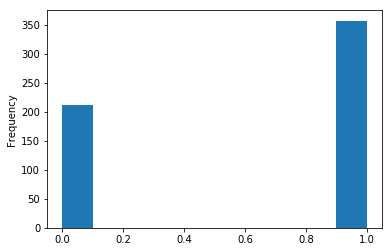

In [8]:
# Acceder al dataset disponible en sklearn y crear el dataframe 'X' para los atributos, y la serie 'y' para la clase
data_raw = load_breast_cancer()

data = pd.DataFrame(data=data_raw['data'], columns=data_raw['feature_names'])
data['class'] = data_raw['target']

#    - Mostrar información sobre las columnas
print(data.columns)

#    - Mostrar indicadores estadísticos sobre las columnas
print(data.describe())

#    - Obtener una matriz numpy con los valores de los datos
X = data.drop('class', axis=1).values
y = data['class'].values

#    - Mostrar los valores de la clase
print(data['class'].unique())
#    - Mostrar la distribución de los valores de la clase
data['class'].plot(kind='hist')

## 1. Entrenamiento de un clasificador <a name="clasificador"> </a>

Entrenar un clasificador es muy simple en Sklearn. Basta con crear un objeto del estimador que queramos entrenar y ejecutar el método <code>fit</code>. En este notebook usaremos uno de los clasificadores que mejor resultado suele dar de los disponibles en Sklearn: <code>LogisticRegression</code>. 

### 1.1 ¿Qué es la regresión logística? ¿Es regresión o clasificación? <a name="logistica"> </a>

Es una técnica que se usa para predecir el resultado de una variable discreta, es por tanto una _técnica de clasificación_. En su formulación más simple (la binaria) se aprende a estimar la probabilidad de que una instancia pertenezca a la clase positiva de la siguiente forma:
- Probabilidades cercanas a $1$ darán lugar a clasificar la instancia como de la clase positiva
- Probabilidades cercanas a $0$ darán lugar a clasificar la instancia como de la clase negativa



El modelo logístico establece la siguiente relación entre la probabilidad de pertenecer a la clase positiva y los valores de los atributos de la instancia $X$:

$$
P(X) = P(y=1\;| \;x_1, x_2, ..., x_n)  = \frac{1}{1+exp(-\alpha-\beta_1x_1-\beta_2x_2...-\beta_nx_n)}
$$

A este tipo de funciones se les denomina _logísticas_ (de ahí el nombre _regresión logística_).

Se puede generalizar a una clasificación no binaria (con $k$ categorías) mediante la construcción de $k-1$ clasificadores binarios.

La función _logit_ nos permite convertir el problema de estimar la probablilidad en un problema de regresión lineal. Esta es la función _logit_:
$$
logit(p) = ln(\frac{p}{1-p})
$$

Y mediante una serie de transformaciones se demuestra que:

$$
logit(P(y=1\;| \;x_1, x_2, ..., x_n)) = \alpha+\beta_1x_1+\beta_2x_2...+\beta_nx_n
$$

Gracias a usar la función _logit_ como función de enlace se consigue una formulación lineal del problema, lo que permite la aplicación de técnicas de regresión lineal (de ahí el nombre _regresión_ logística)  para el aprendizaje de los coeficientes $\alpha$ y $\beta_i$.



### 1.2 Estimadores de Sklearn (_fit_, _predict_ y _predict proba_) <a name="estimadores"> </a>

<code>Sklearn</code> es un paquete muy complejo, y en este notebook solo usaremos algunos elementos del mismo. Los tres conceptos principales para comprender cómo se trabaja con <code>sklearn</code> son:
- **Estimador**: es el mecanismo a través del cual se implementan los distintos algoritmos de aprendizaje automático disponibles en <code>sklearn</code>. Para crear un objeto estimador solo hace falta conocer el nombre de la clase que lo implementa. Por ejemplo <code>clasificador = LogisticRegression()</code>
- **fit**: Es el método que se usa para entrenar un estimador. Es una propiedad del estimador, y basta con pasarle la matriz $X$ y el vector $y$. Por ejemplo, <code>clasificador.fit(X,y)</code> 
- **predict**: Es el método que se usa para predecir a partir de un estimador entrenada. Es una propiedad del estimador, y basta con pasarle la matriz $X\_test$ con las instancias que se desean clasificar. Por ejemplo, <code>clasificador.predict(X_test)</code>

In [9]:
# EJERCICIO: crear un estimador de la clase LogisticRegression y entrenarlo con el dataset <X,y>
clf = LogisticRegression(solver='lbfgs', max_iter=100000)

clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Una vez entrenado un clasificador, podemos usarlo para predecir la clase de un conjunto de instancias con el método <code>predict</code>. Muchos estimadores nos proporcionan también las probabilidades de cada una de las clases gracias al método <code>predict_proba</code>.

In [13]:
# EJERCICIO: predecir la clase de los primeros 10 valores de X con el clasificador entrenado anteriormente
clf.predict(X[0:10])

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [14]:
# EJERCICIO: obtener la probabilidad de cada clase de los primeros 10 valores de X con el clasificador entrenado anteriormente
clf.predict_proba(X[0:10])

array([[1.00000000e+00, 2.69187651e-15],
       [9.99999980e-01, 2.00268142e-08],
       [9.99999962e-01, 3.76756189e-08],
       [4.93931576e-01, 5.06068424e-01],
       [9.99991776e-01, 8.22423537e-06],
       [8.00346768e-01, 1.99653232e-01],
       [9.99999083e-01, 9.17266900e-07],
       [9.82428673e-01, 1.75713269e-02],
       [9.12940843e-01, 8.70591570e-02],
       [9.97444109e-01, 2.55589139e-03]])

In [26]:
preds = clf.predict_proba(X[0:10])

In [27]:
preds

array([[1.00000000e+00, 2.69187651e-15],
       [9.99999980e-01, 2.00268142e-08],
       [9.99999962e-01, 3.76756189e-08],
       [4.93931576e-01, 5.06068424e-01],
       [9.99991776e-01, 8.22423537e-06],
       [8.00346768e-01, 1.99653232e-01],
       [9.99999083e-01, 9.17266900e-07],
       [9.82428673e-01, 1.75713269e-02],
       [9.12940843e-01, 8.70591570e-02],
       [9.97444109e-01, 2.55589139e-03]])

In [28]:
# Así se podrían convertir las probabilidades de nuevo en clases, si hiciera falta
preds = np.argmax(preds,axis=1)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [21]:
preds

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

## 2. Evaluación _train/test_ <a name="evaluacion_tt"> </a>
Las predicciones anteriores se han hecho sobre los mismos datos usados para entrenar el modelo. Para poder evaluar un clasificador de forma fiable es necesario usar datos distintos para el entrenamiento y la validación. Una manera de hacerlo es mediante una partición _train/test_ de los datos originales. En esta sección veremos cómo hacer este tipo de particiones con Sklearn y las utilizaremos para calcular una de las métricas de evaluación más comunes: el _accuracy_.

### 2.1 Separación entrenamiento y validación <a name="separacion"> </a>

In [29]:
# EJERCICIO: dividir el corpus <X, y> en dos <X_train, y_train> y <X_test, y_test> con una distribución 80%-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [30]:
# EJERCICIO: entrenar un clasificador con el corpus <X_train, y_train>
clf = LogisticRegression(solver='lbfgs', max_iter=100000)

clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
# EJERCICIO: predecir la clase para las instancias de X_test y guardar las predicciones en y_test_pred
y_test_pred = clf.predict(X_test)
y_test_pred

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0])

### 2.2 Cálculo del accuracy <a name="accuracy"> </a>

In [32]:
# EJERCICIO: calcular el accuracy de las predicciones comparando y_test e y_test_pred
(y_test == y_test_pred).sum()/(y_test.shape[0])

0.9824561403508771

### 2.3 Probabilidades de pertenencia <a name="pertenencia"> </a>

In [ ]:
# EJERCICIO: calcular las probabilidades de cada clase para las instancias de X_test y guardarlas en y_test_proba
y_test_proba = clf.predict_proba(X_test)
y_test_proba

Como podemos observar aparecen dos probabilidades para cada fila: la probabilidad de elegir la clase $0$ y la probabilidad de elegir la clase $1$. Un análisis de la distribución de estas probabilidades, nos dará pistas sobre si el conjunto de datos a clasificar está _bien separado_. Si es así, habrá pocos casos dudosos al clasificador le costará menos trabajo decidir.

(0, 1)

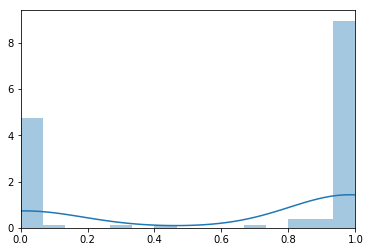

In [12]:
# EJERCICIO: mostrar con un histograma la distribución de la probabilidad de pertenecer a la clase 1
sns.distplot(y_test_proba[:, 1], bins=15)
plt.xlim(0, 1)

(0, 1)

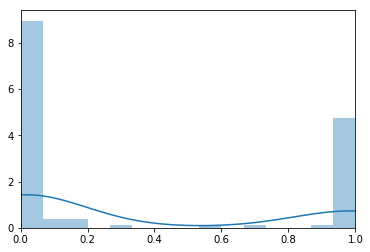

In [13]:
# EJERCICIO: mostrar con un histograma la distribución de la probabilidad de pertenecer a la clase 0
sns.distplot(y_test_proba[:, 0], bins=15)
plt.xlim(0, 1)

## 3. Evaluación mediante validación cruzada <a name="evaluacion_cruzada"> </a>

La evaluación _train/test_ tiene dos principales inconvenientes:
- Desperdicia parte del material de entrenamiento.
- Los resultados son dependientes de la partición, pudiendo ser sensiblemente distintos con otras particiones.

La validación cruzada es un medio para mitigar ambos efectos. Consiste en dividir el dataset en varias carpetas y realizar diferentes evaluaciones usando en cada una de ellas una carpeta distinta como _test_ y el resto de carpetas como _train_. El resultado final de la evaluación se puede calcular mediante la media de todas las evaluaciones.

Los métodos que usaremos son:
- **cross_val_predict**: usa por turnos todas las instancias de $X$ tanto para entrenar, como para predecir, y devuelve un vector $y\_pred$ con las predicciones obtenidas para todas las instancias de $x$. 
- **cross_val_score**: usa por turnos todas las instancias de $X$ tanto para entrenar, como para evaluar, y devuelve una métrica de evaluación (por defecto es la proporción de aciertos).

In [46]:
# EJERCICIO: predecir la clase de todas las instancias mediante validación cruzada y guardar las prediccciones en y_pred
clf = LogisticRegression(solver='lbfgs', max_iter=100000)

y_pred = cross_val_predict(clf, X, y, cv=5)

In [47]:
# EJERCICIO: calcular las probabilidades de cada clase para todas las instancias mediante validación cruzada y guardarlas en y_proba
clf = LogisticRegression(solver='lbfgs', max_iter=100000)

y_proba = cross_val_predict(clf, X, y, cv=5, method='predict_proba')

In [48]:
# EJERCICIO: calcular el accuracy de las predicciones sobre todas las instancias mediante validación cruzada
clf = LogisticRegression(solver='lbfgs', max_iter=100000)

# retornara el accuracy para cada uno de los folds.
y_acc = cross_val_score(clf, X, y, cv=5)

In [49]:
y_acc

array([0.93913043, 0.94782609, 0.98230088, 0.92920354, 0.95575221])

C:\Users\Belladona\Anaconda3\envs\ztdl\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


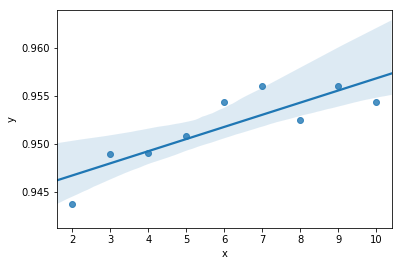

In [50]:
# EJERCICIO:
#    - Calcular el accuracy con distintos números de carpetas en la validación cruzada (p.e. de 2 a 10)
#    - Mostrar los resultados en una gráfica

scores = list()
folds = list(range(2, 11))

for fold in folds:
    clf = LogisticRegression(solver='lbfgs', max_iter=100000)

    y_proba = cross_val_score(clf, X, y, cv=fold).mean()
    
    scores.append(y_proba)

sns.regplot(x='x', y='y', data=pd.DataFrame({'x': folds, 'y': scores}))

## 4. Matriz de confusión, _accuracy_, precisón, cobertura, medida f1, TPR y FPR <a name="matriz_cf"> </a>

A partir de esta sección trabajaremos sobre los resultados de la validación cruzada (mediante las series <code>y</code>, <code>y_pred</code> e <code>y_proba</code>) aunque el análisis podía haberse hecho perfectamente con una evaluación _train/test_. Mostraremos cómo calcular distintas métricas de evaluación. En muchas ocasiones lo haremos de dos formas distintas:
- Con un método ofrecido por Sklearn que suele recibir <code>y</code> e <code>y_pred</code>.
- A partir de las celdas de la matriz de confusión.

### 4.1 Número de aciertos y fallos: TP, FP, TN, FN <a name="aciertos_fallos"> </a>

La matriz de confusión muestra el número de veces que se han producido los distintos tipos de aciertos y fallos. En una clasificación binaria tiene cuatro celdas que suelen denominarse con los siguientes nombres:
- TP: _true positives_
- TN: _true negatives_
- FP: _false positives_
- FN: _false negatives_

In [51]:
clf = LogisticRegression(solver='lbfgs', max_iter=100000)

y_pred = cross_val_predict(clf, X, y, cv=5)

In [52]:
clf = LogisticRegression(solver='lbfgs', max_iter=100000)

y_proba = cross_val_predict(clf, X, y, cv=5, method='predict_proba')

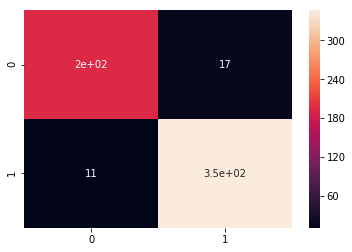

In [53]:
# EJERCICIO: crear la matriz de confusión y mostrarla mediante un mapa de calor
sns.heatmap(metrics.confusion_matrix(y, y_pred),annot=True)

In [56]:
# EJERCICIO: guardar los valores de la matriz de confusión en sus variables correspondientes (TP, TN, FP, FN)
TN, FP, FN, TP = metrics.confusion_matrix(y, y_pred).ravel() # ravel() returns a flattened array

Una de las métricas más usadas es el _accuracy_ que mide directamente el porcentaje de aciertos. Si el dataset está balanceado es un buen indicador, pero si alguna de las clases es muy mayoritaria (o minoritaria) la información que nos dá la métrica puede ser bastante engañosa.

In [57]:
# EJERCICIO: calcular la medida 'accuracy' de dos formas distintas:
#    - Con el método proporcionado por Sklearn
#    - A partir de los componentes de la matriz de confusión
# accuracy = (TP + TN) / (TP + TN + FP + FN)

print(metrics.accuracy_score(y, y_pred))

accuracy = (TP + TN) / (TP + TN + FP + FN)

print(accuracy)

0.9507908611599297
0.9507908611599297


In [59]:
# EJERCICIO: definir una función que reciba un clasificador y muestre el accuracy obtenido y la matriz de confusión
def get_metrics(classifier, X, y):
    y_pred = cross_val_predict(clf, X, y, cv=5)
    print(f'Accuracy: {metrics.accuracy_score(y, y_pred)*100}%')
    print(f'Confusion matrix: {metrics.confusion_matrix(y, y_pred)}')

## 4.2 accuracy, precision, recall y f1 <a name="medidas"> </a>

El siguiente paquete de métricas es el formado por la precisión, cobertura (_recall_) y medida f1. Son métricas que dan diferente importancia al tipo de error (p.e. falsos positivos o falsos negativos en clasificación binaria). Pueden ser de utilidad para sistemas en los que nos preocupan más unos errores que otros: por ejemplo, es menos grave dejar pasar un correo _spam_ que eliminar un correo correcto. El significado intuitivo de las métricas es el siguiente:
- _precision_: grado de acierto en las instancias propuestas como positivas.
- _recall_: porcentaje de recuperación del total de las instancias positivas.
- _f1_ : media armónica de precisión y cobertura.

Al combinar dos métricas complementarias, la medida _f1_ es apropiada para datasets que no estén bien balanceados.

In [24]:
# EJERCICIO: calcular la medida 'precisión' de dos formas distintas:
#    - Con el método proporcionado por Sklearn
#    - A partir de los componentes de la matriz de confusión
print(metrics.precision_score(y, y_pred))
print(TP/(TP+FP))

0.9532967032967034
0.9532967032967034


In [25]:
# EJERCICIO: calcular la medida 'cobertura' (o recall) de dos formas distintas:
#    - Con el método proporcionado por Sklearn
#    - A partir de los componentes de la matriz de confusión
print(metrics.recall_score(y, y_pred))
print(TP/(TP+FN))

0.9719887955182073
0.9719887955182073


In [26]:
# EJERCICIO: calcular la medida 'f1' de dos formas distintas:
#    - Con el método proporcionado por Sklearn
#    - A partir de las medidas 'precisión' y 'cobertura'
print(metrics.f1_score(y, y_pred))
print((2*TP)/((2*TP) + FP + FN))

0.9625520110957004
0.9625520110957004


## 4.3 _True Positive Rate_ y _False Positive Rate_ <a name="rates"> </a>
Las siguientes dos métricas también suelen ir de la mano y, al igual que la precisión y la cobertura, son complementarias. Se trata de TPR (_True Positive Rate_) y FPR (_False Positive Rate_) y se definen de la siguiente forma:

- TPR: positivos correctos (TP) dividido entre todos los positivos (TP+FN). También se denomina a esta métrica _sensibilidad_ y _cobertura_.
- FPR: positivos erróneos (FP) dividido entre todos los negativos (FP+TN). A la métrica $1-FPR$ también se le denomina _especificidad_.

Ambas métricas se suelen combinar en una curva, denominada ROC, que veremos en la siguiente sección.

In [27]:
# EJERCICIO: calcular la medida TPR a partir de los componentes de la matriz de confusión
TPR = TP / (TP+FN)
print(TPR)

0.9719887955182073


In [28]:
# EJERCICIO: calcular la medida FPR a partir de los componentes de la matriz de confusión
FPR = FP / (FP+TN)
print(FPR)

0.08018867924528301


## 5. Curva ROC (TPR-FPR) y curva _Precision-Recall_ <a name="curvas"> </a>

Ambas curvas (y sus correspondientes métricas de agregación) se benefician de la complementariedad de las métricas en las que se apoyan para definir unas métricas que tengan en cuenta los distintos tipos de errores que se pueden cometer.

La principal contribución de estas curvas con respecto a otras métricas es que muestran la calidad del clasificador en distintos escenarios de decisión, diferenciados por el umbral de probabilidad usado para determinar la clase. Esto se puede hacer siempre que dispongamos las probabilidades generadas por <code>predict_proba</code>:

![image.png](attachment:image.png)

Probando distintos umbrales de decisión, obtendremos métricas distintas. Y es, precisamente, con esos puntos con los que se trazan ambas curvas. La definición intuitiva de cada una de ellas es la siguente:
- Curva ROC: unión de puntos (FPR, TPR) con distintos umbrales de decisión. La métrica ROC-AUC resume la curva en un único valor numérico mediante el área que queda bajo ella.
- Curva _Precision-Recall_: unión de puntos (_recall_, _precision_) con distintos umbrales de decisión. La métrica _average precision score_ resume la curva en un único valor numérico mediante el área que queda bajo ella.

El hecho de que ambas curvas integren métricas complementarias y que se apoyen en distintos umbrales de decisión, las hacen muy apropiadas para situaciones en las que el dataset no está balanceado.

In [60]:
# Antes de nada debemos disponer de las probabilidades para la clase 1
# Usaremos 'y_proba' (validación cruzada), aunque también podría hacerse sobre 'y_test_proba' (train/test)
y_proba_clase1 =  pd.Series(y_proba[:,1])

In [63]:
# EJERCICIO: calcular los puntos de la curva ROC mediante el método proporcionado por Sklearn
metrics.roc_curve(y, y_proba_clase1)

(array([0.        , 0.        , 0.        , 0.00471698, 0.00471698,
        0.00943396, 0.00943396, 0.01886792, 0.01886792, 0.02358491,
        0.02358491, 0.02830189, 0.02830189, 0.03301887, 0.03301887,
        0.04245283, 0.04245283, 0.04716981, 0.04716981, 0.05188679,
        0.05188679, 0.05660377, 0.05660377, 0.07075472, 0.07075472,
        0.0754717 , 0.0754717 , 0.08018868, 0.08018868, 0.08490566,
        0.08490566, 0.10377358, 0.10377358, 0.13207547, 0.13207547,
        0.13679245, 0.13679245, 0.14622642, 0.14622642, 0.16509434,
        0.16509434, 1.        ]),
 array([0.        , 0.00280112, 0.59943978, 0.59943978, 0.77871148,
        0.77871148, 0.87955182, 0.87955182, 0.90196078, 0.90196078,
        0.9047619 , 0.9047619 , 0.93277311, 0.93277311, 0.93557423,
        0.93557423, 0.93837535, 0.93837535, 0.94397759, 0.94397759,
        0.95798319, 0.95798319, 0.96358543, 0.96358543, 0.96638655,
        0.96638655, 0.96918768, 0.96918768, 0.9719888 , 0.9719888 ,
        0.9747

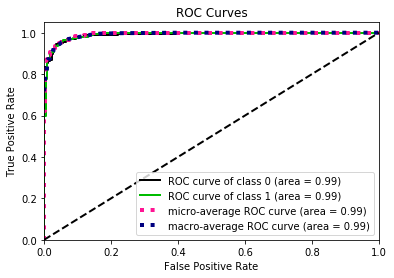

In [62]:
# EJERCICIO: mostrar gráficamente la curva ROC
skplt.metrics.plot_roc(y, y_proba)
plt.show()

In [32]:
# EJERCICIO: calcular la métrica ROC-AUC mediante el método proporcionado por Sklearn
metrics.roc_auc_score(y, y_proba_clase1)

0.9907774430526928

In [67]:
# EJERCICIO: definir una función que reciba un clasificador y muestre la siguiente información:
#       - valores FPRs y TPRs
#       - valores de los umbrales para la curva roc
#       - valor del área bajo la curva
#       - gráfica del área bajo la curva
#

def get_metrics2(classifier, X, y):
    y_pred = cross_val_predict(clf, X, y, cv=5)
    y_proba = cross_val_predict(clf, X, y, cv=5, method='predict_proba')
    
    TN, FP, FN, TP = metrics.confusion_matrix(y, y_pred).ravel()
    
    TPR = TP / (TP+FN)
    print(f'TPR: {TPR}')
    
    FPR = FP / (FP+TN)
    print(f'FPR: {FPR}')
    
    y_proba_clase1 =  pd.Series(y_proba[:,1])
    print(f'ROC Curve: {metrics.roc_curve(y, y_proba_clase1)}')
    
    print(f'AUC ROC: {metrics.roc_auc_score(y, y_proba_clase1)}')
    
    skplt.metrics.plot_roc(y, y_proba)
    plt.show()

In [34]:
# EJERCICIO: calcular los puntos de la curva Precision-Recall mediante el método proporcionado por Sklearn
metrics.precision_recall_curve(y, y_proba_clase1)

(array([0.91071429, 0.91048593, 0.91025641, 0.91002571, 0.91237113,
        0.9121447 , 0.91450777, 0.91688312, 0.91927083, 0.91906005,
        0.92146597, 0.92388451, 0.92368421, 0.92612137, 0.92592593,
        0.92572944, 0.92819149, 0.928     , 0.93048128, 0.93297587,
        0.93548387, 0.93800539, 0.94054054, 0.94308943, 0.94565217,
        0.94822888, 0.94808743, 0.95068493, 0.9532967 , 0.95592287,
        0.9558011 , 0.95567867, 0.95833333, 0.96100279, 0.96368715,
        0.96358543, 0.96629213, 0.96619718, 0.96610169, 0.96600567,
        0.96590909, 0.96581197, 0.96857143, 0.96848138, 0.9683908 ,
        0.97118156, 0.97109827, 0.97101449, 0.97383721, 0.97667638,
        0.97953216, 0.98240469, 0.98235294, 0.98230088, 0.98224852,
        0.98219585, 0.98214286, 0.98208955, 0.98203593, 0.98198198,
        0.98192771, 0.98489426, 0.98484848, 0.98480243, 0.9847561 ,
        0.98776758, 0.98773006, 0.98769231, 0.98765432, 0.9876161 ,
        0.98757764, 0.98753894, 0.9875    , 0.98

Text(0.5, 1.0, 'Prec-Recall curve')

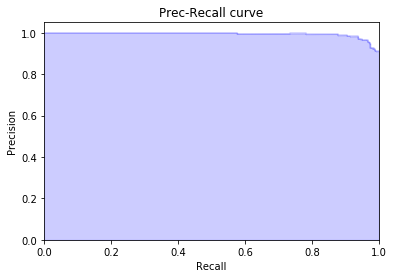

In [35]:
# EJERCICIO: mostrar gráficamente la curva Precision-Recall
from sklearn.utils.fixes import signature

precision, recall, _ = metrics.precision_recall_curve(y, y_proba_clase1)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Prec-Recall curve')

In [36]:
# EJERCICIO: calcular la métrica average_precision_score mediante el método proporcionado por Sklearn
print(metrics.average_precision_score(y, y_proba_clase1))

0.9942337916781663


## 6. Otros clasificadores <a name="otros_clasif"> </a>

### 6.1. Árboles de Decisión <a name="arboles"> </a>

Un árbol de decisión es una estructura que nos permite responder a preguntas complejas, mediante una secuencia ordenada de preguntas simples.

La clasificación automática basada en árboles de decisión consiste en la creación de un árbol de este tipo a partir de un conjunto de datos. Es uno de los métodos más versátiles y populares. Tiene, además, la ventaja de que el modelo que se construye es interpretable por las personas.

#### 6.1.1. Análisis del dataset con Árboles de Decisión

In [64]:
# EJERCICIO: Repetir el análisis anterior haciendo uso del clasificador DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [65]:
get_metrics(clf, X, y)

Accuracy: 91.3884007029877%
Confusion matrix: [[194  18]
 [ 31 326]]


TPR: 0.9215686274509803
FPR: 0.09905660377358491
ROC Curve: (array([0.        , 0.08490566, 1.        ]), array([0.        , 0.91596639, 1.        ]), array([2., 1., 0.]))
AUC ROC: 0.9155303630886316


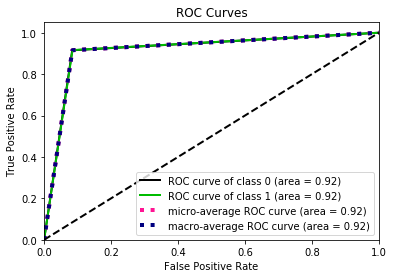

In [68]:
# EJERCICIO: Análisis ROC 
get_metrics2(clf, X, y)


#### 6.1.2 Interpretación de resultados con Árboles de Decisión

Algunos modelos asociados a algoritmos de aprendizaje (como ocurre con los árboles de decisión) son interpretables. Esto significa que del modelo se pueden extraer reglas, o patrones, comprensibles para las personas. En este ejercicio usaremos una característica del estimador <code>DecisionTreeClassifier</code> que nos permite visualizar el árbol construido tras ser entrenado. 

Para ello nos apoyaremos en el paquete <code>graphviz</code> que permite visualizar grafos. La instrucción para instalar <code>graphviz</code> desde la consola de <code>anaconda</code> es:
- <code>conda install python-graphviz</code>

In [71]:
# EJERCICIO: Visualizar los dos primeros niveles del árbol resultante de entrenar el estimador DecisionTreeClassifier con los datos X e y.
# nota: hacer uso de Source y tree.export_graphviz
from IPython.display import Image  

clf = DecisionTreeClassifier()
clf.fit(X, y)

dot_data = tree.export_graphviz(clf,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

#Image(graph.create_png())

### 6.2. Random Forest <a name="randomF"> </a>

Random forest es un método que combina una cantidad grande de árboles de decisión independientes probados sobre conjuntos de datos aleatorios con igual distribución.

Accuracy: 96.30931458699473%
Confusion matrix: [[199  13]
 [  8 349]]
TPR: 0.9775910364145658
FPR: 0.06132075471698113
ROC Curve: (array([0.        , 0.00471698, 0.00471698, 0.00943396, 0.01415094,
       0.01415094, 0.01415094, 0.01415094, 0.01415094, 0.01415094,
       0.01415094, 0.01415094, 0.01415094, 0.01415094, 0.01415094,
       0.01886792, 0.01886792, 0.01886792, 0.01886792, 0.01886792,
       0.01886792, 0.01886792, 0.02830189, 0.02830189, 0.03301887,
       0.03301887, 0.04245283, 0.04245283, 0.05188679, 0.05188679,
       0.05660377, 0.07075472, 0.08018868, 0.08018868, 0.08962264,
       0.08962264, 0.0990566 , 0.10849057, 0.11320755, 0.13207547,
       0.13679245, 0.14150943, 0.14150943, 0.14622642, 0.16037736,
       0.16509434, 0.18396226, 0.19811321, 0.20754717, 0.21698113,
       0.23584906, 0.25      , 0.25943396, 0.27358491, 0.29245283,
       0.30660377, 0.3254717 , 0.3490566 , 0.36320755, 0.4009434 ,
       0.43396226, 0.48584906, 0.58490566, 1.        ]), array([0

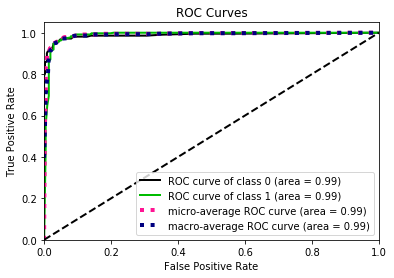

In [72]:
# EJERCICIO: Repetir el análisis anterior haciendo uso del clasificador RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

get_metrics(clf, X, y)

get_metrics2(clf, X, y)